# Udacity Project - Data Analysis of Bay Area Bike Share

## Introduction

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

In this project, we will perform data wrangling as well as an exploratory analysis on the Bay Area Bike Share data.

## Questions
Before we even start looking at data, let's think of some questions that we want to understand about the bike share users. 

### Question 1
Currently, there is an overage fee for rides longer then 30 minutes. Is this optimal though? What does the typical ride time look like? It could benefit Bay Area Bike Share to change their overage fees based on the typical ride of a user.

* Are there any usage trends in the data for length of ride times?

### Question 2
Right now packages are broken out into yearly, 24-hour, as well as 3-day passes. Is this optimal though? In order to improve the bike service pricing package let's look at usage trends to see if there are peak days where the bike share is being used more often. 

* Are there any usage trends in the data for specific days of the week where bike share is utilized the most?

### Question 3
It's also important for us to understand how the bike share is being used in various cities. Let's explore the data and see if there are certain cities where the bikes are being used more often. From understanding this we can add more bikes in certain cities as well as change pricing based on demand.

* Are there specific cities where bike share is used more then other cities?

## Data Wrangling

Now it's time to start exploring the data. We'll be using Year 1 and Year 2 data from the Bay Area Bike Share's [Open Data](http://www.bayareabikeshare.com/open-data). The data comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). 

There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

When dealing with a lot of data, it can be useful for us to start by working with only a sample of the data. This way, it will be much easier to check that the data wrangling steps are working, since our code will take less time to complete. Once we are satisfied with the way things are working, we can then set things up to work on the dataset as a whole. In this section of the analysis let's perform wrangling on a subset of the data.

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. We'll start by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. Below we will take the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).

First, we'll load all of the packages and functions that we'll be using in the analysis. Then, we'll read a subset of the first trip data file, and write a new file containing just the subset we are initially interested in.

In [1]:
# Import Python Libraries
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from IPython.display import display

# Import Local Files
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot

# Display Plots Inline
%matplotlib inline

In [2]:
# File Locations
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # CSV reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # Write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # Trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step we'll take is to look at the structure of the dataset to see if there's any data wrangling we should perform. Let's read in the sampled data file that we created in the previous cell, and print out the first few rows of the table.

In [3]:
# Display Sample Data
sample_data = pd.read_csv('201309_trip_data.csv')
display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, we're going to concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. We will also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. Let's create the station-city mapping. As a note it is possible that more stations are added or dropped over time, let's create a function that will allow us to combine the station information across all three parts of our data when we are ready to explore everything.

In [4]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('201402_station_data.csv')
display(station_info.head())

# Create the mapping.
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # Set up CSV reader object
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [5]:
# Use the mapping to condense the trip data to the selected columns noted above
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # Generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # Set up CSV writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # Set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # Collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # Convert duration units from seconds to minutes
                    new_point['duration'] = float(row['Duration'])/60.0
                    
                    # Reformat datestrings into multiple columns
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%A')
                    
                    # Remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    
                    # Two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # Write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [6]:
# Process the data by running the function we wrote above.
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


All counts are as expected!


## Exploratory Data Analysis

Now that we have some data, let's look at some initial trends in the data.

In [7]:
# Read in Trip Data
trip_data = pd.read_csv('201309_trip_summary.csv')

# Get Usage Statistics
usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

We see that there are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration. In fact, the mean is larger than the 75% shortest durations. This will be interesting to look at later on.

Let's start looking at how those trips are divided by subscription type, to do this let's plot the data!

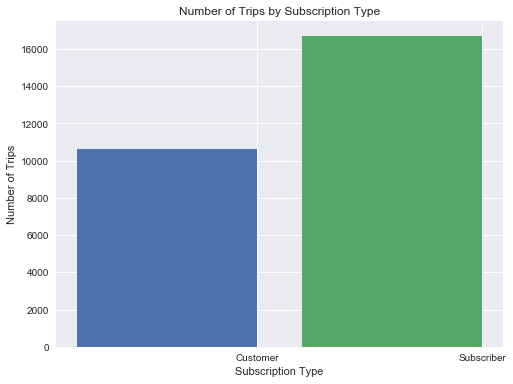

In [8]:
usage_plot(trip_data, 'subscription_type')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. 

What does the distribution of trip durations look like?

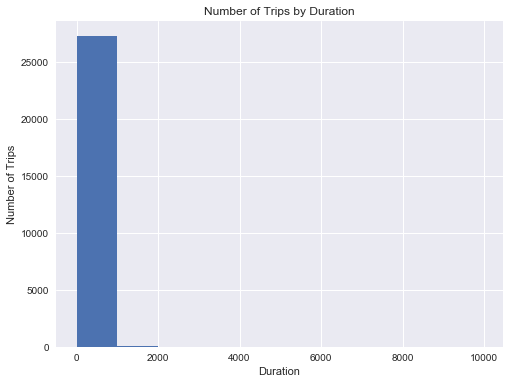

In [9]:
usage_plot(trip_data, 'duration')

Looks pretty strange... Let's take a look at the duration values on the x-axis. Most rides are expected to be 30 minutes or less, since there are overage charges for taking extra time in a single trip. The first bar spans durations up to about 1000 minutes, or over 16 hours. From our previous analysis, we should have expected some trips with very long durations that bring the average to be so much higher than the median: the plot shows this in a dramatic, but unhelpful way.

When exploring the data, let's work with visualization function parameters in order to make the data easier to understand. Let's start by limiting things to trips of less than 60 minutes.

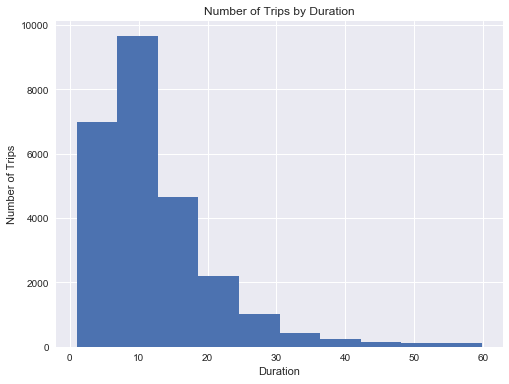

In [10]:
usage_plot(trip_data, 'duration', ['duration < 60'])

This is looking better! We can see that most trips are indeed less than 30 minutes in length. Let's pretty up the graph though and make each bar count up data points in five-minute intervals.

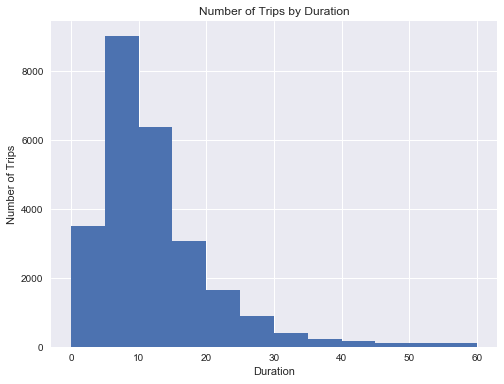

In [11]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

From looking at the plot 5 to 10 minute trips are the most popular. Interesting!

## Answering Our Questions

Now that we've done some exploration on a small sample of the dataset, it's time to put together all of the data in a single file and see what trends we can find. First let's process all the data into a single data file.

In [12]:
# Variables for Processing
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and write out a new data file
summarise_data(trip_in, station_data, trip_out)

In [13]:
# Load the Data Set
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thursday,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thursday,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thursday,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thursday,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thursday,San Francisco,San Francisco,Subscriber


Now let's explore the new full dataset.

In [14]:
# Bike Share Usage Statistics
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

### Question 1
The first question we had was to look at trip duration to see if we can find any usage trends. To analyze this, let's plot the number of trips by the trip duration.

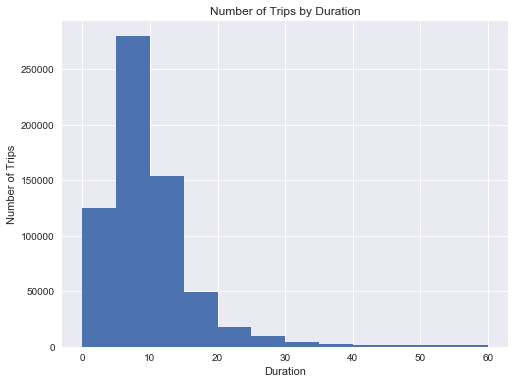

In [15]:
# Number of Trips by Duration
usage_plot(trip_data, 'duration', ['duration < 60'],boundary = 0, bin_width = 5)

From looking at the graph, trip durations of 5 to 10 minutes are the most popular and most trips look to be less then 20 minutes, with very few trips lasting longer then 30. Maybe charging overages after 30 minutes is not ideal, maybe shifting overages to be on trips over 20 minutes is more ideal as the overages can bring in more revenue?

### Question 2

As discussed earlier in the project the passes are broken up into 24 hour, and 3 Day passes. Is this optimal though? A key insight we can derive from the data is weekly usage and understanding our peak and lull days. Let's plot number of trips by day of the week.

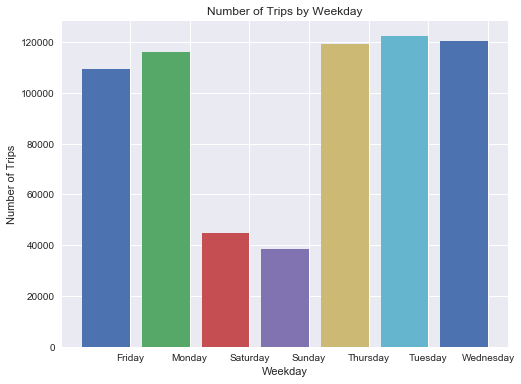

In [16]:
# Number of Trips By Weekday
usage_plot(trip_data, 'weekday')

As we can see from the graph above, on weekdays (Monday-Friday) there are more bike share trips than on weekends (Saturday & Sunday). Maybe the price package of a 3-Day pass isn't ideal. From looking at the data maybe we break our packages into a week day pass for our weekly commuters, or potentially into a weekend pass that will incentivize users to ride on weekends.

### Question 3

To circle back on our final  question we posed, we determined a useful insight is looking at the cities where the Bike Share service is used the most. Let's plot the data by Number of Trips and Start City to see what the data shows us.

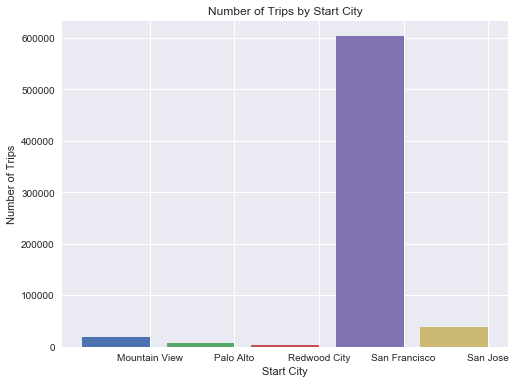

In [17]:
# Number of Trips by Start City
usage_plot(trip_data, 'start_city')

As we can see above, San Francisco is overwhelmingly the city where most bikes are used. For further analysis it might be worth looking into why SF uses bikes so much than the other cities and if there are things we can do in the other citeis to increase the number of trips.

> We can export the Notebook output in a form that can be opened even for those without Python installed. From the **File** menu in the upper left, go to the **Download as** submenu. You can then choose a different format that can be viewed more generally, such as HTML (.html) or PDF (.pdf). You may need additional packages or software to perform these exports.